In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [2]:
columnNames= [
    'id number',
    'Clump Thickness',
    'Uniformity of Cell Size',
    'Uniformity of Cell Shape',
    'Marginal Adhesion',
    'Single Epithelial Cell Size',
    'Bare Nuclei',
    'Bland Chromatin',
    'Normal Nucleoli',
    'Mitoses',
    'Class']  

#(2 for benign, 4 for malignant)
labels=['Benigno', 'Maligno']

In [3]:
df =  pd.read_csv('breast-cancer-wisconsin.data.txt', header= None, names= columnNames)

In [4]:
df.head()

,id number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [5]:
# Descartamos el id del paciente.
df.drop('id number',axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
Clump Thickness                699 non-null int64
Uniformity of Cell Size        699 non-null int64
Uniformity of Cell Shape       699 non-null int64
Marginal Adhesion              699 non-null int64
Single Epithelial Cell Size    699 non-null int64
Bare Nuclei                    699 non-null object
Bland Chromatin                699 non-null int64
Normal Nucleoli                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: int64(9), object(1)
memory usage: 54.7+ KB


In [7]:
# Estudio de la columna Bare Nuclei al ser objeto
df['Bare Nuclei'].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: Bare Nuclei, dtype: int64

In [8]:
# Voy a sustituir los valores ? con la moda para no descartar el paciente.
# Convertir a numerica
df['Bare Nuclei'].replace('?', 1, inplace= True)
df['Bare Nuclei']= df['Bare Nuclei'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
Clump Thickness                699 non-null int64
Uniformity of Cell Size        699 non-null int64
Uniformity of Cell Shape       699 non-null int64
Marginal Adhesion              699 non-null int64
Single Epithelial Cell Size    699 non-null int64
Bare Nuclei                    699 non-null int64
Bland Chromatin                699 non-null int64
Normal Nucleoli                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: int64(10)
memory usage: 54.7 KB


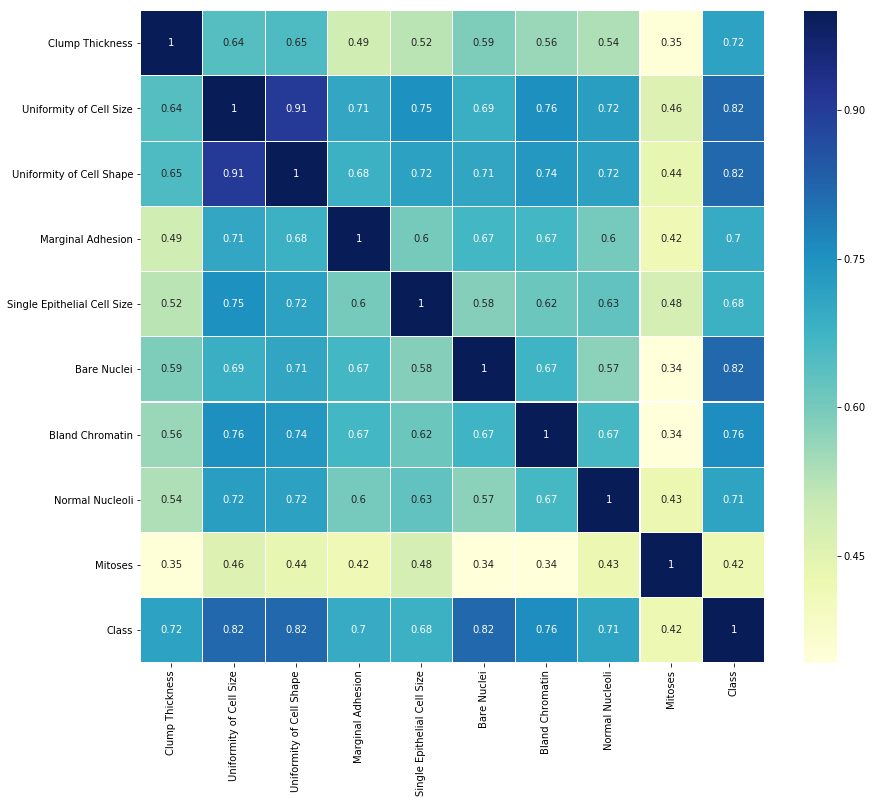

In [9]:
# Visualizamos la matriz de correlación.
# Solo hay 2 columnas con 0.91, al ser pocas y con valor no muy alto decido no tocarlas.
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);

In [10]:
X=df.drop('Class', axis=1)
y=df['Class']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [12]:
'''
En las siguientes celdas, hasta los clasificadores son pruebas mías.
Hacer un solo modelo. 
Ver la matriz de confusion en bruto.
Ver el accuracy.
Predecir valores introducidos a mano.
'''
knClf= KNeighborsClassifier()
knClf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [13]:
y_predict= knClf.predict(X_test)

In [14]:
confusion_matrix(y_test, y_predict)

array([[93,  2],
       [ 1, 44]])

In [15]:
accuracy_score(y_test, y_predict)

0.9785714285714285

In [16]:
#Pasar la serie al formato necesario de array para predict.
sujetoBenigno= X_test.iloc[2].values.reshape(1, -1)

In [17]:
sujetoMaligno= [[5,4,4,5,7,10,3,2,1]]

In [18]:
value_predict= knClf.predict(sujetoMaligno)
value_predict

array([4])

In [19]:
# Clasificadores seleccionados.
classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="rbf", C=0.025, probability=True, gamma='scale'),
    NuSVC(probability=True, gamma='scale'),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

In [20]:
# Función para sacar el gráfico de la matriz de confusión.
# Le pasamos la matriz, clases, y params. opcionales.
# El de normalizar es el más interesante.

def print_confusion_matrix(confusion_matrix, class_names, 
                           figsize = (12,10), fontsize=14, title='Confusion matrix', normalize=False):
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        
    fmt = '.2f' if normalize else 'd'
    
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names,     )
    
    fig = plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.savefig('output/'+title+'-CM.png', bbox_inches='tight')
    plt.show()

In [21]:
# Función para pintar la curva ROC
def print_roc_curve(fpr, tpr, title='(ROC) Curve', figsize = (12,10)):  
    fig = plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.savefig('output/'+title+'-ROC.png', bbox_inches='tight')
    plt.show()

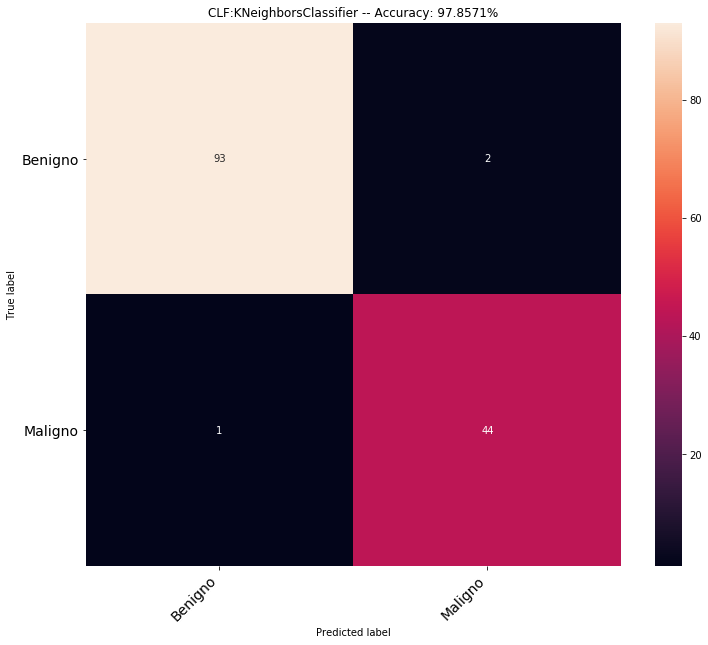

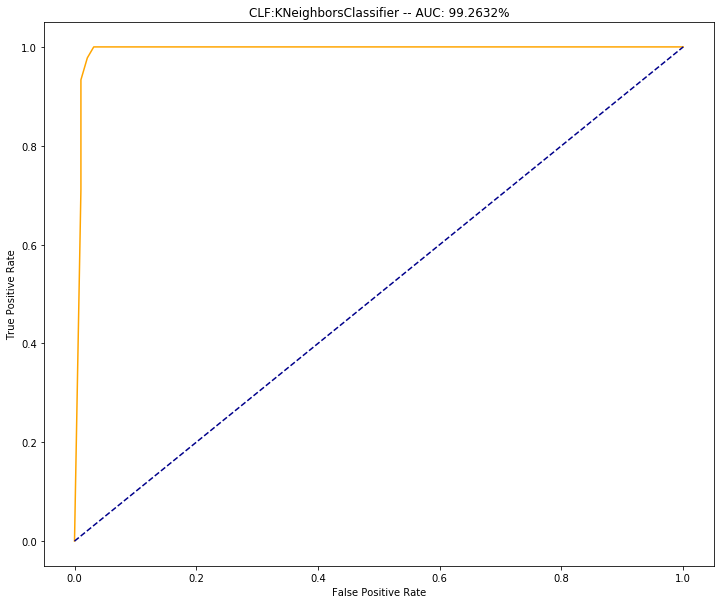

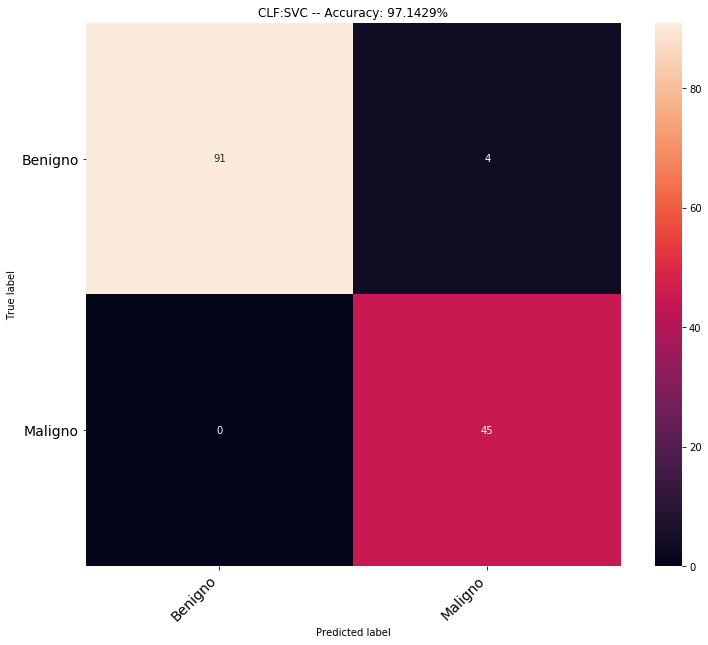

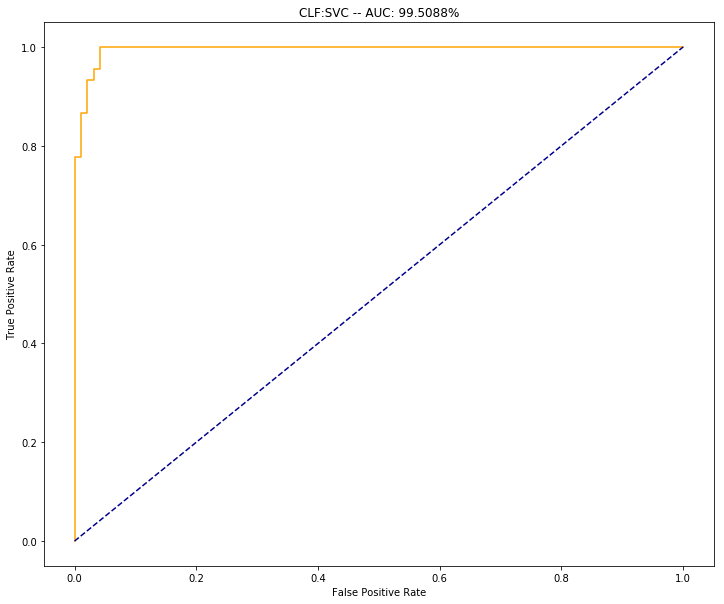

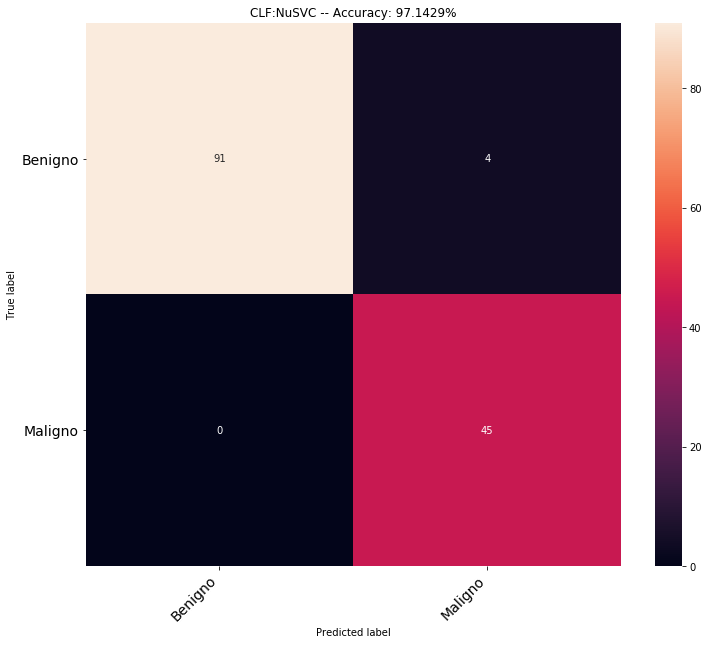

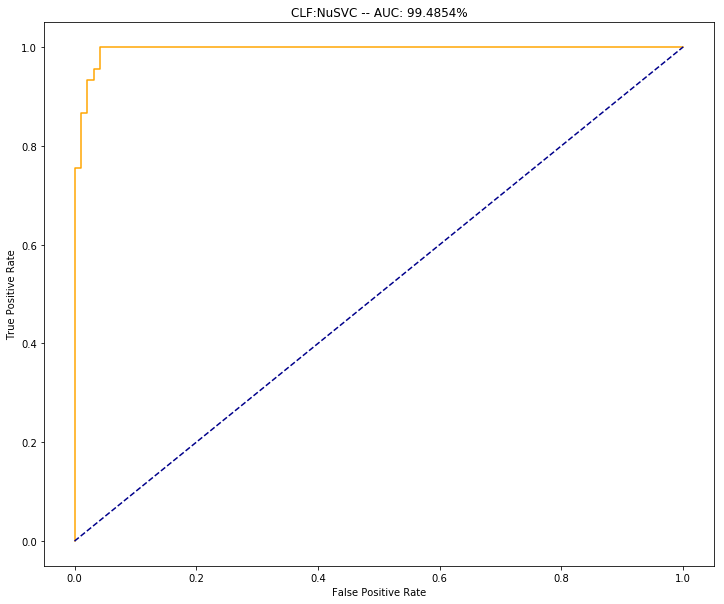

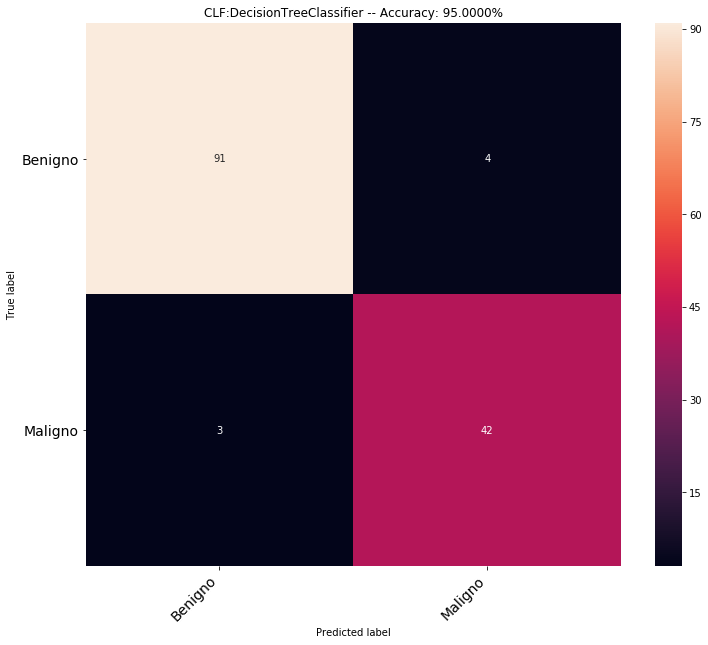

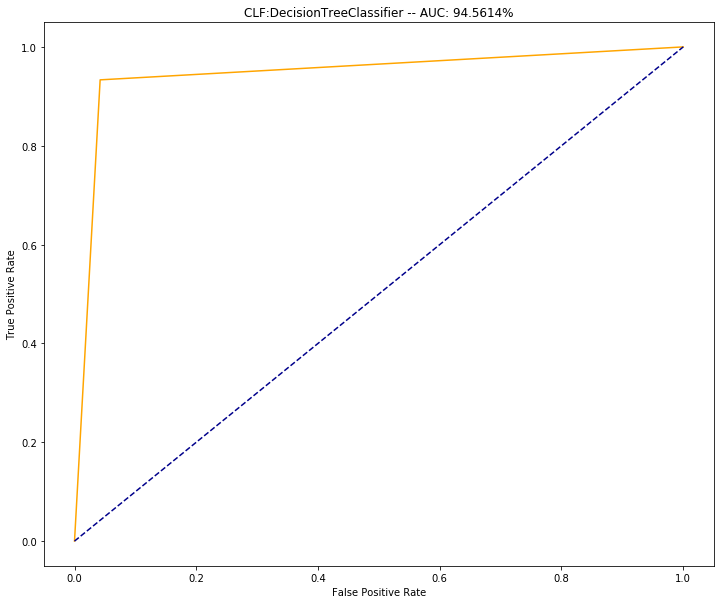

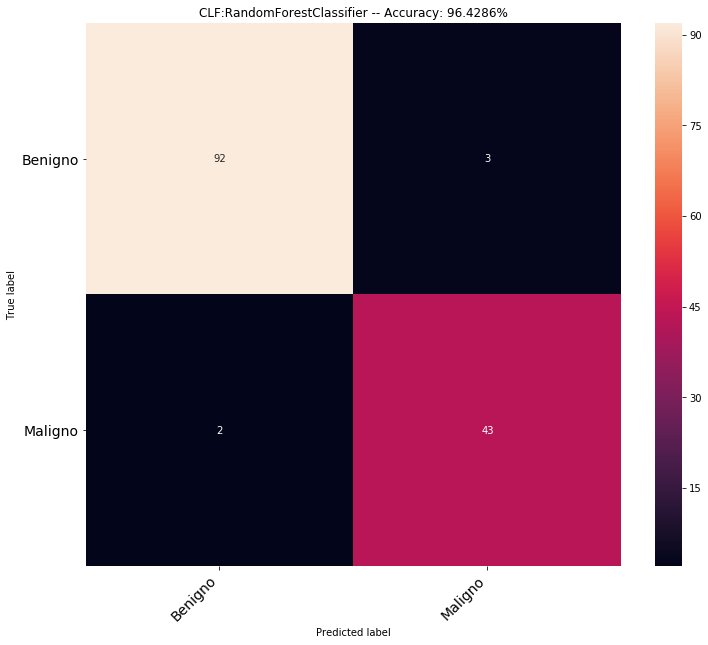

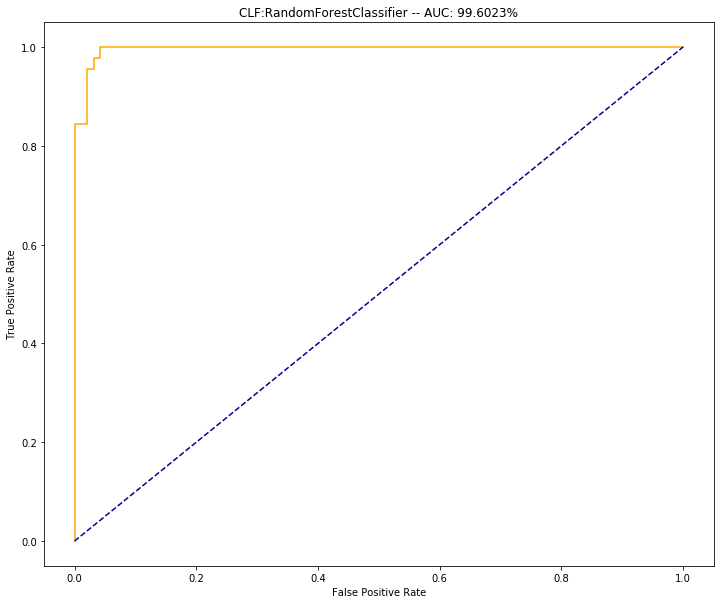

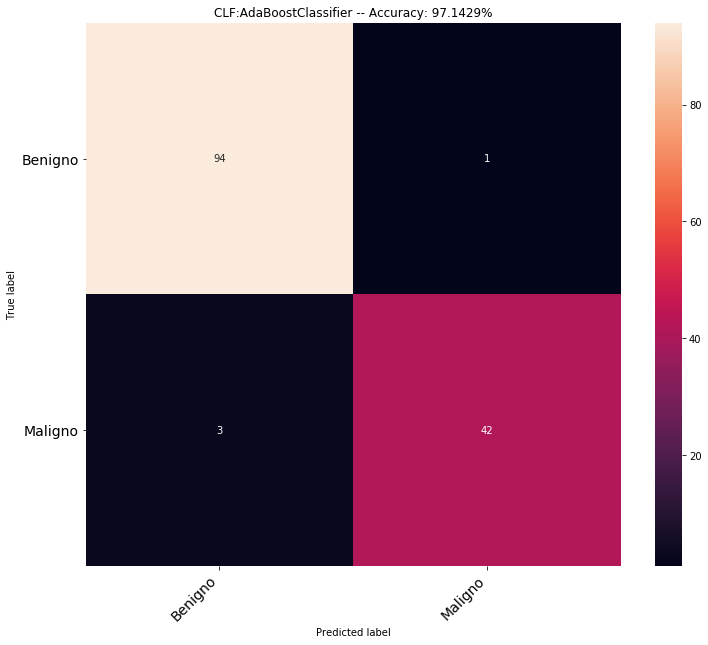

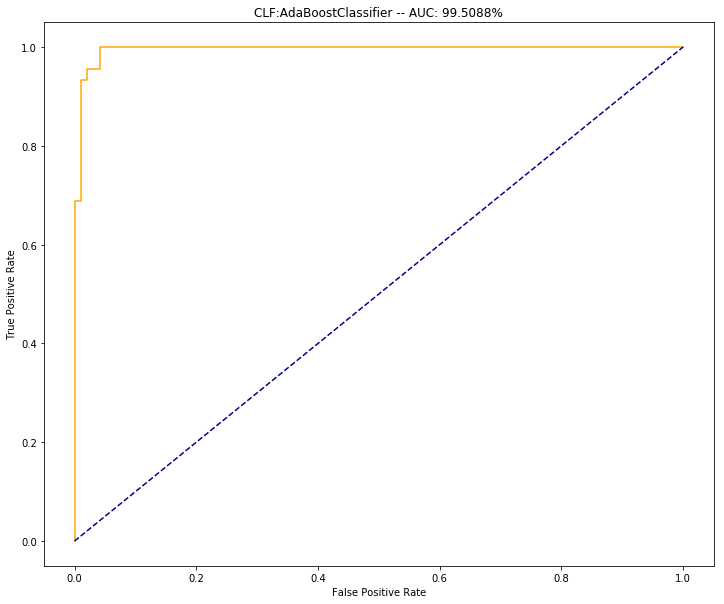

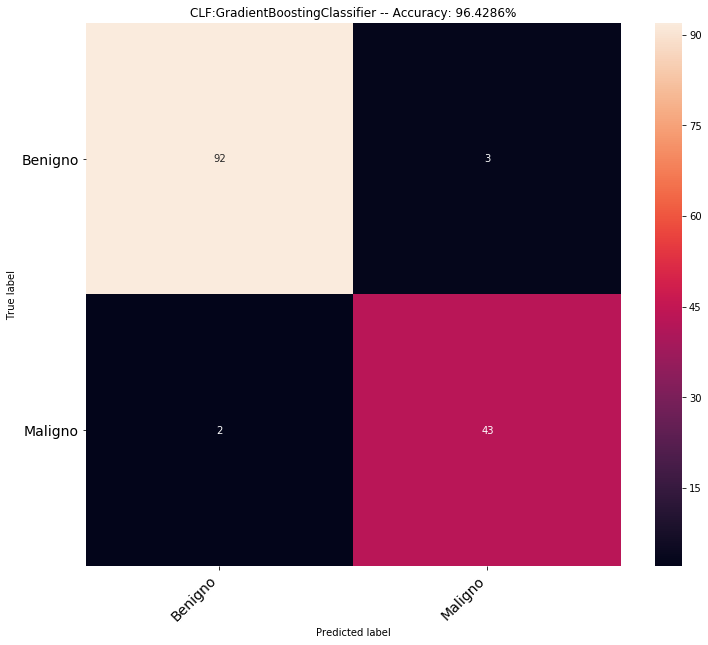

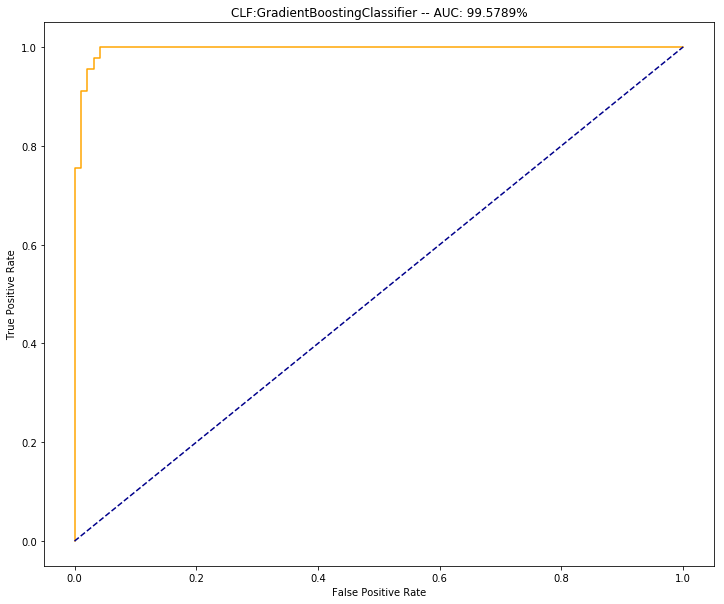

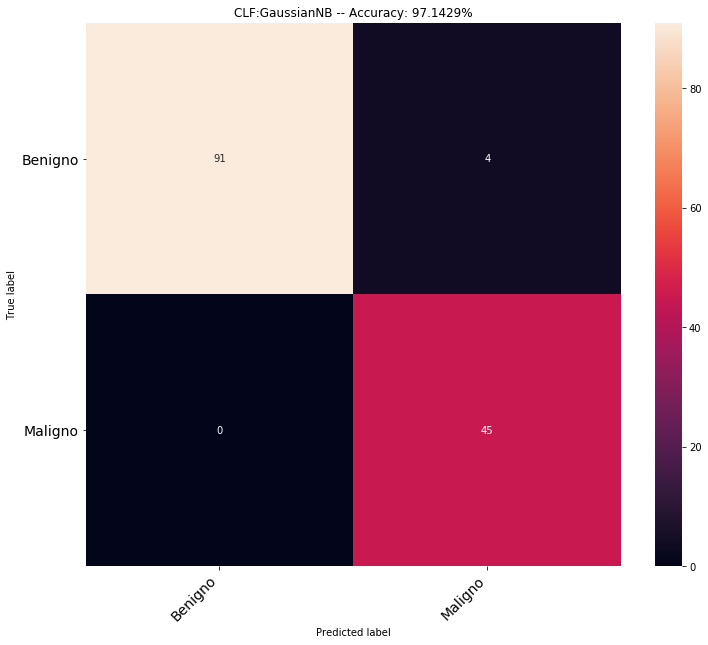

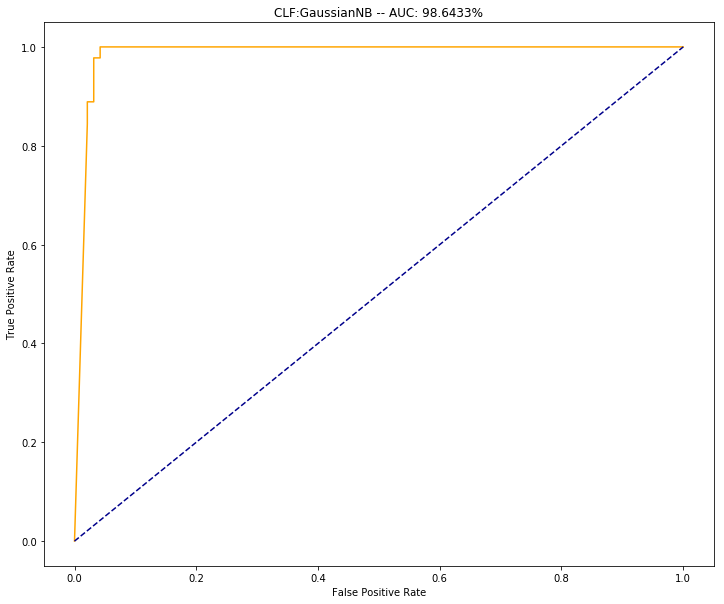

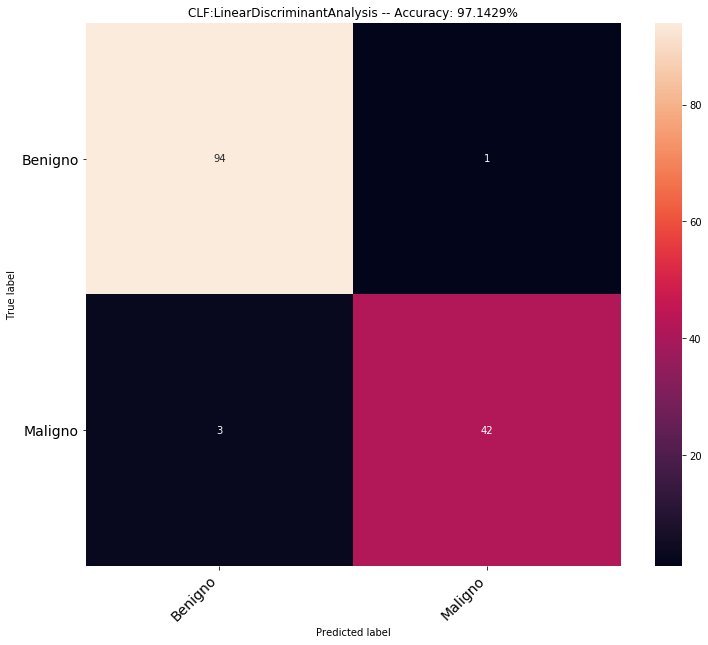

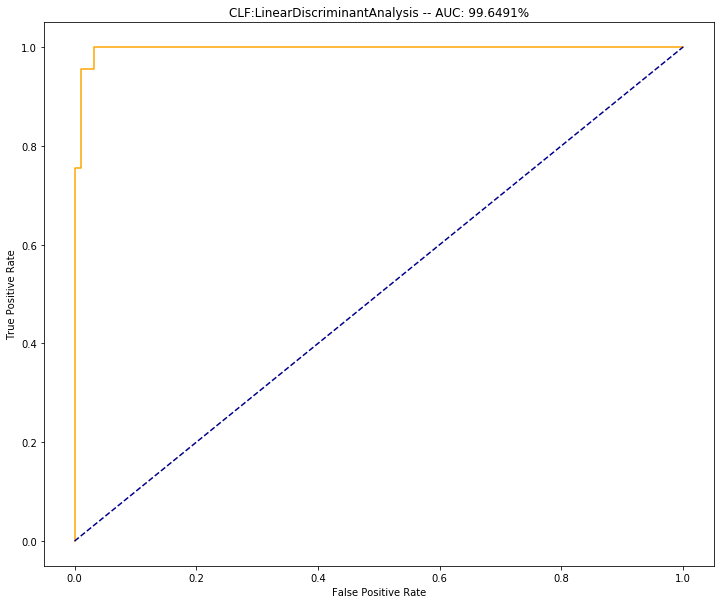

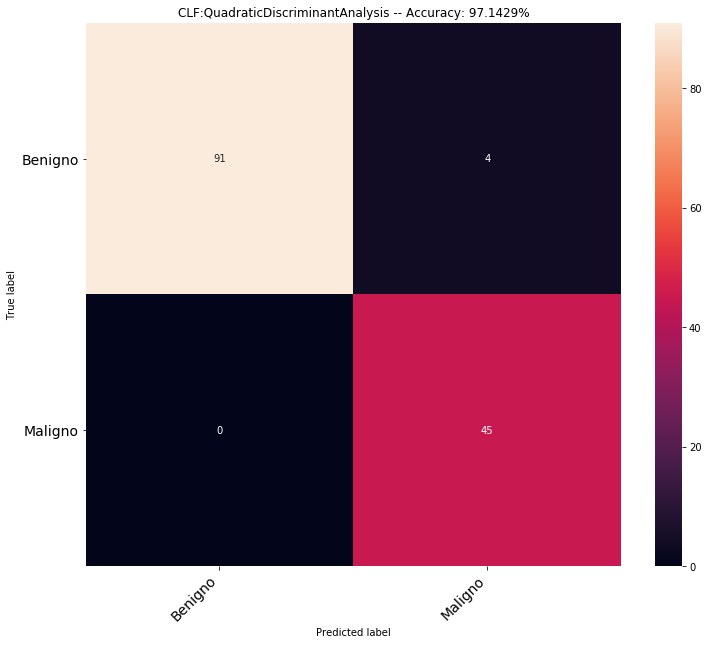

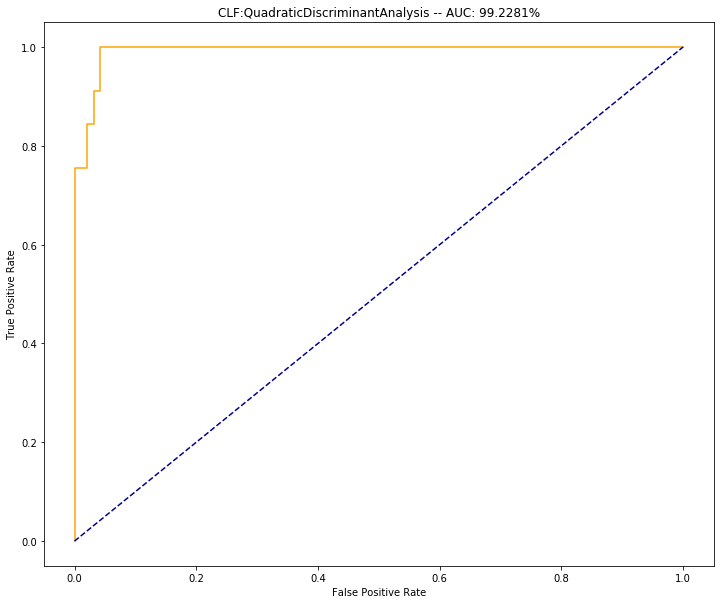

In [22]:
# Creo un DataFrame para guardar los resultados.
log_cols=["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

#Recorrer los clasificadores generando los gráficos.
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    # Valores para matriz.
    y_predict = clf.predict(X_test)
    acc = accuracy_score(y_test, y_predict)
    
    # Valores para curva ROC.
    probs = clf.predict_proba(X_test)
    # Nos quedamos solo con los valores 1
    preds = probs[:, 1]
    # Creo y_test_bin para pasar a binario las clases ya que con 2 y 4 da error.
    y_test_bin= y_test.replace(2,0)
    y_test_bin= y_test_bin.replace(4,1)
    fpr, tpr, thresholds = roc_curve(y_test_bin, preds)
    
    cm= confusion_matrix(y_test, y_predict)
    auc = roc_auc_score(y_test, preds)
    
    print_confusion_matrix(cm, labels , title='CLF:{} -- Accuracy: {:.4%}'.format(name, acc))
    print_roc_curve(fpr, tpr, title='CLF:{} -- AUC: {:.4%}'.format(name, auc))
    
    log_entry = pd.DataFrame([[name, acc*100]], columns=log_cols)
    log = log.append(log_entry)

In [23]:
log

,Classifier,Accuracy
0,KNeighborsClassifier,97.857143
0,SVC,97.142857
0,NuSVC,97.142857
0,DecisionTreeClassifier,95.000000
0,RandomForestClassifier,96.428571
0,AdaBoostClassifier,97.142857
0,GradientBoostingClassifier,96.428571
0,GaussianNB,97.142857
0,LinearDiscriminantAnalysis,97.142857
0,QuadraticDiscriminantAnalysis,97.142857


In [24]:
# Grid searching para el mejor de los clasificadores.
param_grid={
    'n_neighbors':[3, 5, 10, 20, 40], 
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'weights':['uniform', 'distance'],
    'p': [1,2],
    'leaf_size': [5,10,20,40]
    }
grid=GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, iid=True, return_train_score=True)
grid.fit(X_train, y_train)
print ('Test acierto: {:.2f}'.format(grid.score(X_test, y_test)))
print ('Mejores parametros: {}'.format(grid.best_params_))
print ('Mejor acierto cross-val: {:.2f}'.format(grid.best_score_))
print ('Mejor estimador: \n{}\n'.format(grid.best_estimator_))

Test acierto: 0.98
Mejores parametros: {'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Mejor acierto cross-val: 0.97
Mejor estimador: 
KNeighborsClassifier(algorithm='auto', leaf_size=5, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')



In [25]:
#Afinamos algunos hiper params.
param_grid={
    'n_neighbors':[2,3,4,5], 
    'algorithm':['auto'], 
    'weights':['uniform'],
    'p': [1],
    'leaf_size': [1,2,3,4,5,6,7,8,9,10]
    }
grid=GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, iid=True, return_train_score=True)
grid.fit(X_train, y_train)
print ('Test acierto: {:.2f}'.format(grid.score(X_test, y_test)))
print ('Mejores parametros: {}'.format(grid.best_params_))
print ('Mejor acierto cross-val: {:.2f}'.format(grid.best_score_))
print ('Mejor estimador: \n{}\n'.format(grid.best_estimator_))

Test acierto: 0.97
Mejores parametros: {'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Mejor acierto cross-val: 0.97
Mejor estimador: 
KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=1,
           weights='uniform')

